In [1]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
eval = pl.read_csv("model_eval_situations.csv",separator=";",infer_schema_length=0)
eval = (eval
        .with_columns([
            pl.col("down").cast(pl.Int32()),
            pl.col("yards_to_go").cast(pl.Int32()),
            pl.col("count").cast(pl.Int32()).alias("count")
            ])
        .sort(pl.col(["down","yards_to_go"]))
        .with_columns(x = pl.concat_str(pl.col("down"), pl.col("yards_to_go")))
        )

Über eine fachliche Prüfung heraus habe ich die Annahme entwickelt, dass das Modell teilweise einfach nur rät und ihm zu wenig Daten zu Grunde liegen.
Daher möchte ich mir anzeigen lassen, mit wie vielen Datenpunkten wir es je Down & Distance zu tun haben:

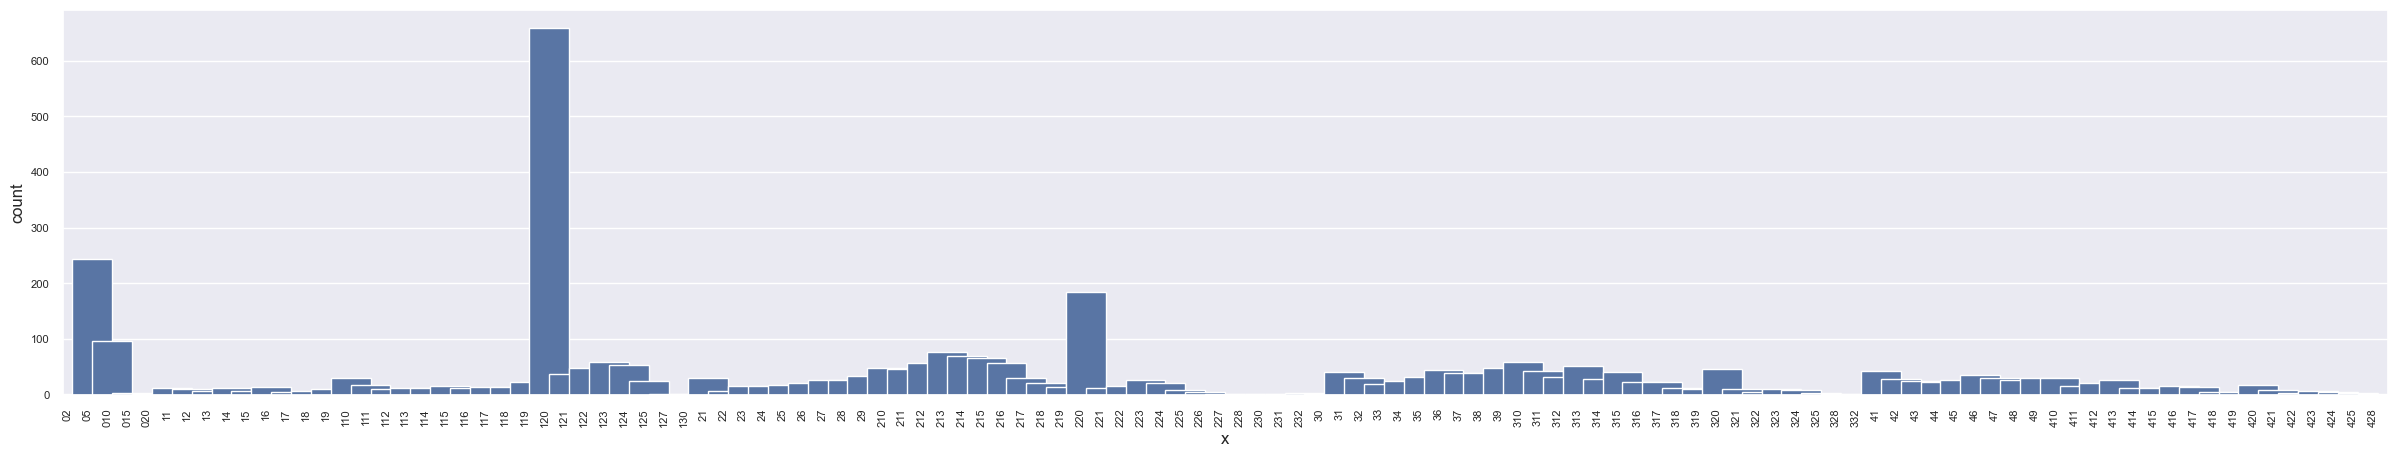

In [21]:
plt.figure(figsize=(30,5))
plt.tick_params(labelsize=8)
plt.xticks(rotation=90, ha='right')
sns.set(style="darkgrid")
a = sns.barplot(data=eval, x="x", y="count", width = 2)
plt.show()
fig = a.get_figure()
fig.savefig("out.png",dpi=400) 

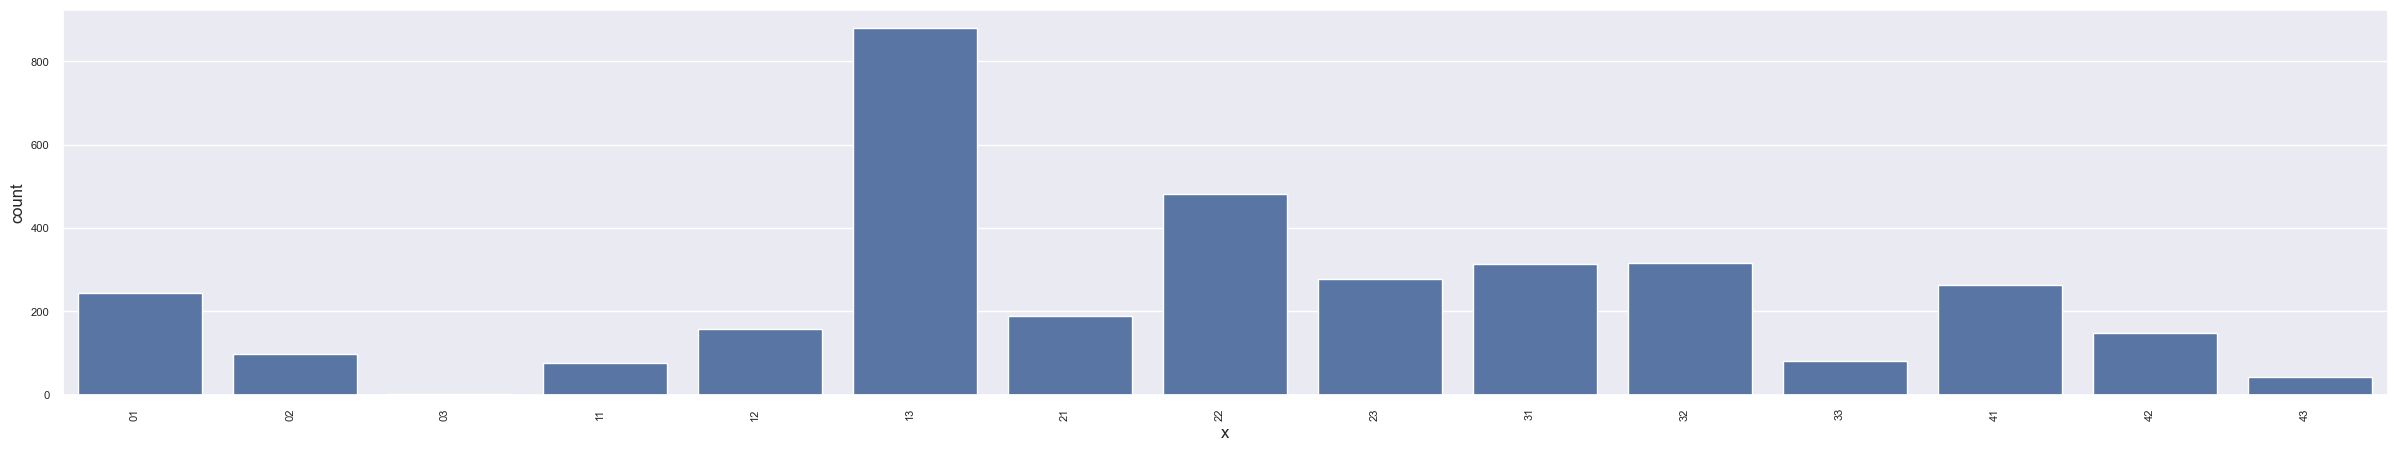

In [7]:
eval = pl.read_csv("model_eval_situations_ydstogosimple2.csv",separator=";",infer_schema_length=0)
eval = (eval
        .with_columns([
            pl.col("down").cast(pl.Int32()),
            pl.col("yards_to_go_simple").cast(pl.Int32()),
            pl.col("count").cast(pl.Int32()).alias("count")
            ])
        .sort(pl.col(["down","yards_to_go_simple"]))
        .with_columns(x = pl.concat_str(pl.col("down"), pl.col("yards_to_go_simple")))
        )

plt.figure(figsize=(30,5))
plt.tick_params(labelsize=8)
plt.xticks(rotation=90, ha='right')
sns.set(style="darkgrid")
a = sns.barplot(data=eval, x="x", y="count")
plt.show()
fig = a.get_figure()
fig.savefig("out_ydstogo.png",dpi=400) 

Erste Erkenntnis:
Ich werde im Modell die Spalte "yardline_50" durch eine andere Konnotation ersetzen. Dafür werde ich alles was sich vor der Mittellinie befindet als "1" und alles was dahinter liegt als "2" setzen.

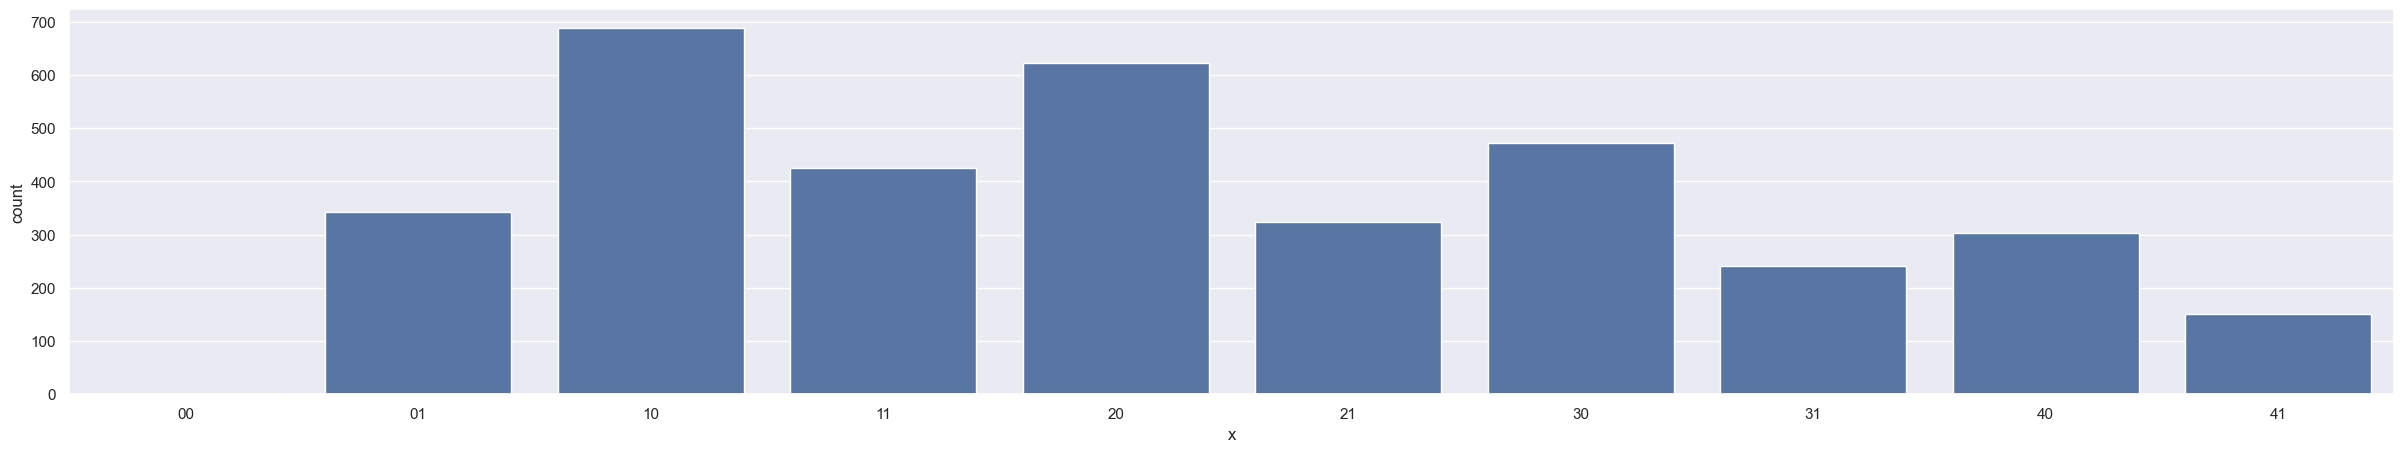

In [37]:
eval_simple = pl.read_csv("model_eval_situations_simple.csv",separator=";",infer_schema_length=0)
eval_simple = (eval_simple
        .with_columns([
            pl.col("down").cast(pl.Int32()),
            pl.col("yardline_50_simple").cast(pl.Int32()),
            pl.col("count").cast(pl.Int32()).alias("count")
            ])
        .sort(pl.col(["down","yardline_50_simple"]))
        .with_columns(x = pl.concat_str(pl.col("down"), pl.col("yardline_50_simple")))
        )
plt.figure(figsize=(30,5))
sns.set(style="darkgrid")
a = sns.barplot(data=eval_simple, x="x", y="count")
plt.show()
fig = a.get_figure()
fig.savefig("out_simple.png",dpi=400) 

In [31]:
eval_simple

down,yardline_50_simple,count
str,str,str
"""3""","""1""","""241"""
"""4""","""0""","""303"""
"""1""","""1""","""425"""
"""2""","""1""","""324"""
"""1""","""0""","""689"""
"""2""","""0""","""623"""
"""0""","""1""","""342"""
"""0""","""0""","""1"""
"""3""","""0""","""472"""


Für PAT müssen wir feste Punkte nehmen, da diese sonst zu stark vom nächsten Event beeinflusst werden.
Dazu nehmen wir alles an Daten was wir haben und errechnen einen Prozentsatz von der 5 und der 10 Yard Linie an guten Versuchen:

In [11]:
df2 = (pl.read_csv("df2.csv",separator=";",infer_schema_length=0)
       .select(["down","yards_to_go","one_point_conv_success","two_point_conv_success"])
       .with_columns(
           down = pl.col("down").cast(pl.Int32()),
           yards_to_go = pl.col("yards_to_go").cast(pl.Int32()),
           one_point_conv_success = pl.col("one_point_conv_success").cast(pl.Int32()),
           two_point_conv_success = pl.col("two_point_conv_success").cast(pl.Int32())
       )
       )

pat = (df2
        .filter(pl.col("down") == 0)
        .group_by('yards_to_go')
        .agg(
            n = pl.col('one_point_conv_success').count(),
            one_good = pl.col('one_point_conv_success').sum(),
            two_good = pl.col('two_point_conv_success').sum()
            )
        .with_columns(
            good = pl.col("one_good") + pl.col("two_good"),
        )
        .with_columns(
            good_pct = pl.col("good") / pl.col("n"),
        )
)

pat

yards_to_go,n,one_good,two_good,good,good_pct
i32,u32,i32,i32,i32,f64
15,2,0,0,0,0.0
20,1,0,0,0,0.0
5,250,123,1,124,0.496
2,1,0,0,0,0.0
10,99,3,42,45,0.454545


Tries von der 5 Yard Linie sind zu 50% gut und Tries von der 10 Yard Linie zu 46%. 
Das bedeutet, dass ein 1Pt-Try Expected Points von 1 * 0.5 = 0.5 hat, während ein 2Pt-Try Expected Points von 2 * 0.46 = 0.92 hat.
Generell bedeutet dass, dass 2Pt Tries deutlich effizienter sind!